In [2]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [3]:
nu = notebookUtils()
model_name = "anomaly_test"

In [4]:
dataset, features, indicators = nu.loadData(indicators=[('moh', 'time', ''), ('tod', 'time', ''), ('dow', 'time', ''), ('bop', 'close', ''),('optimal_v2', 'close', '')],
                            param_spec={},
                            optimal_threshold={'buy':(0.005, 0.03)},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [10,30,60]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,30]},
                                    {'indicator_name':'natr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [30,60,120,180]},
                                    {'indicator_name':'cmo',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2,3,5,10,60]}
                                    ],
                            scale='minmaxwindow')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi

Loading data from XLM...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from EOS...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from ADA...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from ETC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from WAVES...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from BTC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from LINK...
Loading data from chunk 0...
Loading data from chunk 1...
Loading da

In [5]:
dataset.drop(["time", "open", "high", "low", "volume"], axis=1, inplace=True)
dataset.dropna(inplace=True)
dataset

,close,MOH,TOD,DOW,BOP,optimal,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
15179,0.213041,0,0,0,0.687500,0.0,0.435286,0.729316,0.634043,0.597317,...,0.659005,0.376819,0.452686,0.527840,0.587273,0.983078,0.927570,0.842098,0.734874,0.654741
15180,0.212720,0,0,0,0.000000,0.0,0.340551,0.683872,0.505392,0.567618,...,0.621956,0.374251,0.452515,0.529439,0.589722,0.326830,0.479507,0.598773,0.635610,0.630132
15181,0.212565,0,0,0,0.441176,0.0,0.294662,0.661860,0.450078,0.552845,...,0.604542,0.364935,0.446969,0.526431,0.587786,0.198476,0.354921,0.509488,0.592124,0.618419
15182,0.212388,0,0,0,0.450000,0.0,0.242141,0.636666,0.368640,0.536844,...,0.584834,0.358005,0.443117,0.524777,0.587095,0.104518,0.245429,0.419799,0.544377,0.605113
15183,0.212194,0,0,0,0.500000,0.0,0.184826,0.609173,0.307505,0.524461,...,0.563688,0.352683,0.440395,0.524022,0.587233,0.051405,0.163063,0.338374,0.495445,0.590741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11372817,0.266492,1,0,0,0.147059,0.0,0.255396,0.362258,0.284114,0.611841,...,0.630412,0.113270,0.172141,0.303976,0.447565,0.015181,0.091303,0.295482,0.545450,0.618749
11372818,0.264596,0,0,0,0.095721,0.0,0.481620,0.298983,0.076697,0.511225,...,0.422151,0.151410,0.201203,0.328211,0.470459,0.001325,0.013916,0.076710,0.237001,0.495313
11372819,0.263288,0,0,0,0.211382,0.0,0.289371,0.179997,0.174678,0.441314,...,0.338492,0.174365,0.219174,0.343369,0.484848,0.000586,0.007403,0.046659,0.164272,0.431916
11372820,0.263844,0,0,0,0.989627,0.0,0.385415,0.242025,0.335221,0.485557,...,0.394782,0.189026,0.230421,0.351780,0.491699,0.321918,0.235254,0.210408,0.270861,0.467071


In [6]:
X = dataset.iloc[:int(len(dataset)*0.8)]
y = dataset.iloc[-int(len(dataset)*0.2):]
y

,close,MOH,TOD,DOW,BOP,optimal,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_10,CCI_close_period_30,...,RSI_close_period_30,NATR_close_period_30,NATR_close_period_60,NATR_close_period_120,NATR_close_period_180,CMO_close_period_2,CMO_close_period_3,CMO_close_period_5,CMO_close_period_10,CMO_close_period_60
9107365,3.578005,0,0,0,0.750000,0.0,0.400969,0.184332,0.865872,0.427932,...,0.317540,0.168738,0.189559,0.215119,0.253818,0.982069,0.905578,0.653236,0.398355,0.333981
9107366,3.579002,0,0,0,0.500000,0.0,0.599304,0.266743,0.755219,0.432497,...,0.333266,0.165510,0.187497,0.213628,0.252528,0.990953,0.943544,0.743917,0.454402,0.342286
9107367,3.578001,0,0,0,0.500000,0.0,0.400277,0.233371,0.540298,0.419776,...,0.324925,0.162503,0.185605,0.212342,0.251489,0.496883,0.587788,0.560256,0.411810,0.337221
9107368,3.580001,0,0,0,0.625000,0.0,0.444287,0.300018,0.763045,0.456074,...,0.356144,0.167150,0.188434,0.214346,0.253154,0.831814,0.806427,0.728025,0.513703,0.353813
9107369,3.583500,0,0,0,0.400000,0.0,0.575926,0.520845,0.774827,0.492401,...,0.406241,0.174636,0.193063,0.217611,0.255848,0.949501,0.919095,0.851843,0.636867,0.381648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11372817,0.266492,1,0,0,0.147059,0.0,0.255396,0.362258,0.284114,0.611841,...,0.630412,0.113270,0.172141,0.303976,0.447565,0.015181,0.091303,0.295482,0.545450,0.618749
11372818,0.264596,0,0,0,0.095721,0.0,0.481620,0.298983,0.076697,0.511225,...,0.422151,0.151410,0.201203,0.328211,0.470459,0.001325,0.013916,0.076710,0.237001,0.495313
11372819,0.263288,0,0,0,0.211382,0.0,0.289371,0.179997,0.174678,0.441314,...,0.338492,0.174365,0.219174,0.343369,0.484848,0.000586,0.007403,0.046659,0.164272,0.431916
11372820,0.263844,0,0,0,0.989627,0.0,0.385415,0.242025,0.335221,0.485557,...,0.394782,0.189026,0.230421,0.351780,0.491699,0.321918,0.235254,0.210408,0.270861,0.467071


In [25]:
contamination_val = (len(X[X['optimal'] > 0.005]) / len(X))*2
contamination_val

0.026281287097154705

In [26]:
clf = IsolationForest(random_state=69420, contamination=contamination_val).fit(X)

In [27]:
preds = clf.predict(y)

In [28]:
graphing = y[['close']]
graphing['classify'] = preds
graphing['close']
graphing[graphing['classify']==-1]

,close,classify
9107639,3.613000,-1
9107641,3.619250,-1
9107642,3.621625,-1
9107644,3.623406,-1
9107645,3.623203,-1
...,...,...
11372498,0.269646,-1
11372499,0.270308,-1
11372500,0.270789,-1
11372501,0.271190,-1


In [39]:
smaller_graphing = graphing[10000:12000]
smaller_graphing.reset_index(inplace=True)
smaller_graphing['classify'].unique()
copy_smaller_graphing = smaller_graphing.copy()

<Figure size 432x288 with 0 Axes>

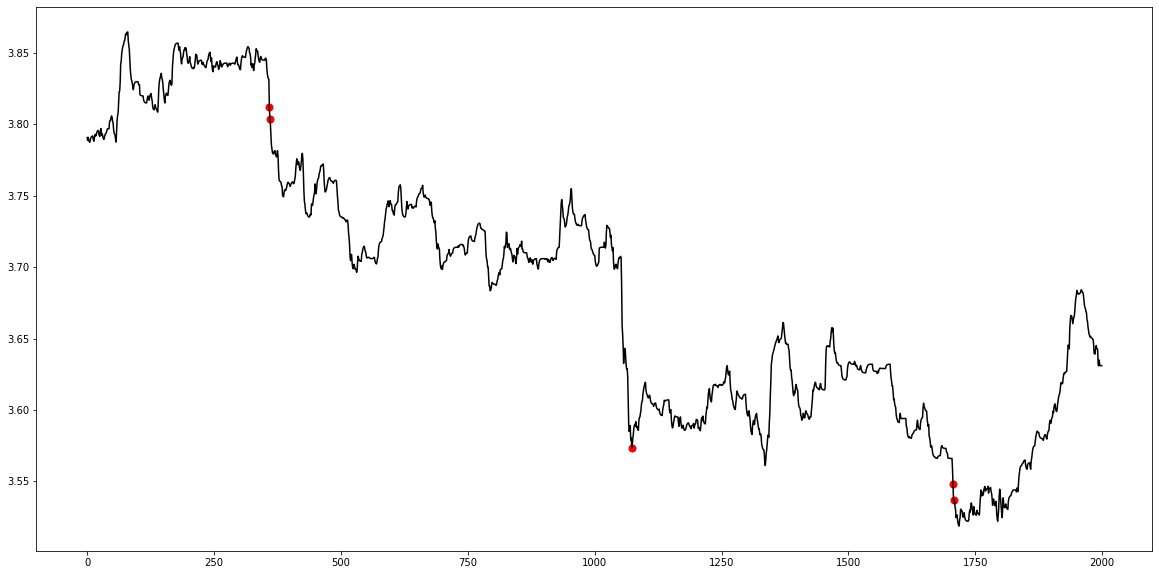

In [40]:
nu.graphPoints(copy_smaller_graphing, mode="buy", plot_optimal=False, plot_sma=False, fields=[], value_match=-1)